In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(engine,reflect=True)

In [7]:
# We can view all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = base.classes.measurement
station = base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [12]:
from sqlalchemy import inspect

In [22]:
#let's see what variables we have so we don't have to keep referencing the sqlite file
inspector = inspect(engine)
type(measurement);
measurement_var = inspector.get_columns('measurement') #this returns a list of dictionaries
for var in measurement_var:
    print(var['name'],var['type'])

print('-------')

station_var = inspector.get_columns('station') 
for var in station_var:
    print(var['name'],var['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
-------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [24]:
from sqlalchemy import desc

The most recent date in our date is 2017-08-23.
The date 1 year before is 2016-08-23.


Text(0, 0.5, 'inches')

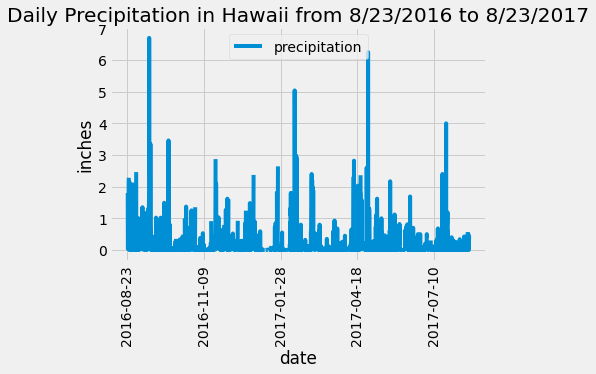

In [62]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
date = session.query(measurement.date).order_by(desc(measurement.date)).first()[0]
print(f'The most recent date in our date is {date}.')
      
# Calculate the date 1 year ago from the last data point in the database
prev_year = (dt.datetime.strptime(date , '%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d') #didn't really want it in datetime format
print(f'The date 1 year before is {prev_year}.')

# Perform a query to retrieve the date and precipitation scores
measurement_data = (measurement.date,measurement.prcp)
type(measurement_data);
prcp_data = session.query(*measurement_data).filter(measurement.date >= prev_year).all() #keep forgetting the *

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_data,columns=['date','precipitation'])

# Sort the dataframe by date
prcp_sort = prcp_df.set_index('date').sort_index()
prcp_sort.head();

# Use Pandas Plotting with Matplotlib to plot the data
prcp_sort.plot(rot=90)
plt.title('Daily Precipitation in Hawaii from 8/23/2016 to 8/23/2017')
plt.ylabel('inches')

In [63]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_sort.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [107]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(station.id)).all()[0][0]


9

In [98]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations_desc = session.query(measurement.station,func.count(measurement.station)).group_by(measurement.station).\
                order_by(desc(func.count(measurement.station))).all()
stations_desc

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [99]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temp_stats = session.query(func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs)).\
    filter(measurement.station == 'USC00519281').all()[0]

min_temp = temp_stats[0]
max_temp = temp_stats[1]
avg_temp = temp_stats[2]

print(f'The lowest temperature recorded was {min_temp} degrees.')
print(f'The highest temperature recorded was {max_temp} degrees.')
print(f'The average temperature was {round(avg_temp,1)} degrees.')

The lowest temperature recorded was 54.0 degrees.
The highest temperature recorded was 85.0 degrees.
The average temperature was 71.7 degrees.


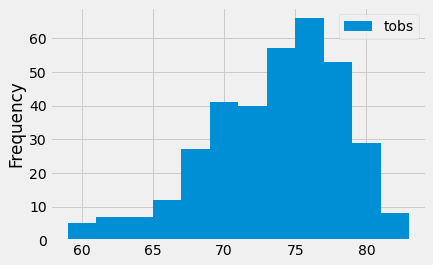

In [105]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_obs_station = session.query(measurement.date,measurement.tobs).filter(measurement.station == 'USC00519281').\
    filter(measurement.date >= prev_year).all()
most_obs_df = pd.DataFrame(most_obs_station)
most_obs_df.plot(kind='hist',bins=12)

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
